In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive


In [ ]:
!pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

In [30]:
!unzip "/content/human-emotions-datasethes.zip" -d "/content/dataset/"

Archive:  /content/human-emotions-datasethes.zip
replace /content/dataset/Emotions Dataset/Emotions Dataset/test/angry/101071.jpg_rotation_1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [31]:
train_directory='/content/dataset/Emotions Dataset/Emotions Dataset/train'
val_directory='/content/dataset/Emotions Dataset/Emotions Dataset/test'
Class_names=os.listdir(train_directory)
print(Class_names)
CONFIGURATION={
    'batch_size':32,
    'im_size':(256,256),
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
}

['happy', 'angry', 'sad']


In [47]:
train_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['batch_size'],
    image_size=CONFIGURATION['im_size'],
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [33]:
val_dataset=tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=Class_names,
    color_mode='rgb',
    batch_size=CONFIGURATION['batch_size'],
    image_size=CONFIGURATION['im_size'],
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [34]:
for i in val_dataset.take(1):
  print(i)

(<tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 20.        ,  20.        ,  20.        ],
         [ 19.1875    ,  19.1875    ,  19.1875    ],
         [ 19.        ,  19.        ,  19.        ],
         ...,
         [ 29.125     ,  29.125     ,  29.125     ],
         [ 25.        ,  25.        ,  25.        ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.        ,  20.        ,  20.        ],
         [ 19.847656  ,  19.847656  ,  19.847656  ],
         [ 19.8125    ,  19.8125    ,  19.8125    ],
         ...,
         [ 28.820312  ,  28.820312  ,  28.820312  ],
         [ 25.660156  ,  25.660156  ,  25.660156  ],
         [ 25.        ,  25.        ,  25.        ]],

        [[ 20.6875    ,  20.6875    ,  20.6875    ],
         [ 21.246094  ,  21.246094  ,  21.246094  ],
         [ 21.847656  ,  21.847656  ,  21.847656  ],
         ...,
         [ 25.3125    ,  25.3125    ,  25.3125    ],
         [ 22.375     ,  22.375     ,  22.375 

### Dataset Visualization

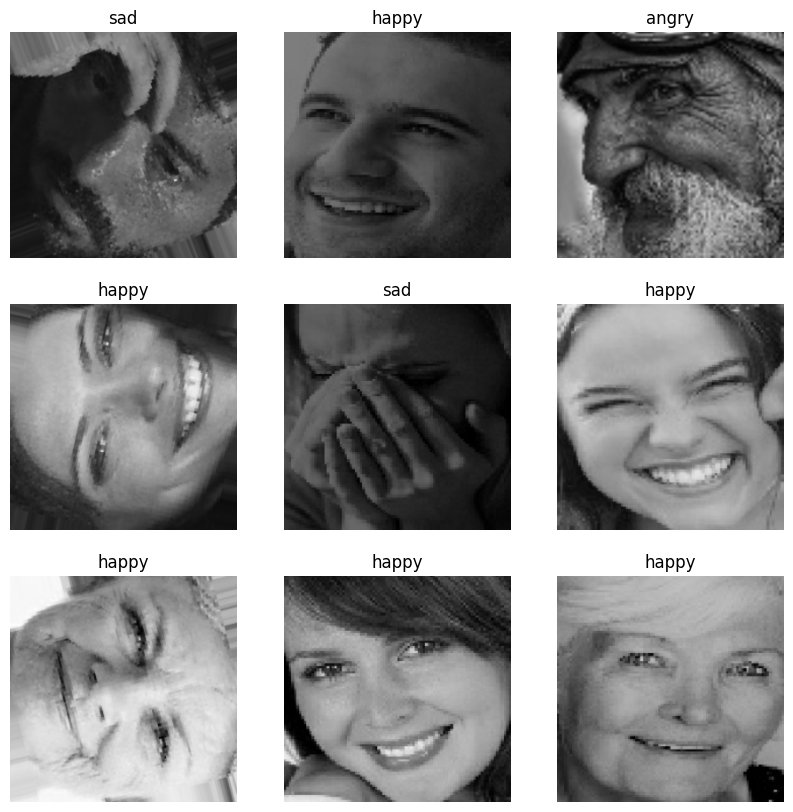

In [35]:
plt.figure(figsize=(10,10))
for images,labels in train_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title(Class_names[np.argmax(labels[i])])
    plt.axis('off')

## Dataset Augmentation

In [36]:
augment_layers=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomContrast(0.2),
])

In [37]:
def augment_layer(image,labels):
  return augment_layers(image,training =True),labels

### Dataset Preparation

In [48]:
train_dataset=(
    train_dataset
   .map(augment_layer,tf.data.AUTOTUNE)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)
val_dataset=val_dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

In [50]:
 resize_rescale_layers=tf.keras.Sequential([
     tf.keras.layers.Resizing(CONFIGURATION['im_size'][0],CONFIGURATION['im_size'][1]),
     tf.keras.layers.Rescaling(1./255)
 ])

###Modeling

In [51]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_8 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │      62,981,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 128)                 │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,118,451 (240.78 MB)

 Trainable params: 63,116,103 (240.77 MB)

 Non-trainable params: 2,348 (9.17 KB)

In [52]:
loss_function = CategoricalCrossentropy()
#loss_function = SparseCategoricalCrossentropy()

In [53]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [54]:
lenet_model.compile(
  optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
  loss = loss_function,
  metrics = metrics,
)

In [ ]:
history = lenet_model.fit(
  train_dataset,
  validation_data = val_dataset,
  epochs = CONFIGURATION["N_EPOCHS"],
  verbose = 1,
)

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 94s 387ms/step - accuracy: 0.4668 - loss: 1.2314 - top_k_accuracy: 0.7650 - val_accuracy: 0.4359 - val_loss: 1.1345 - val_top_k_accuracy: 0.7739
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 77s 359ms/step - accuracy: 0.5431 - loss: 0.9627 - top_k_accuracy: 0.8194 - val_accuracy: 0.4618 - val_loss: 1.0386 - val_top_k_accuracy: 0.8007
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 366ms/step - accuracy: 0.5622 - loss: 0.9289 - top_k_accuracy: 0.8298 - val_accuracy: 0.5623 - val_loss: 0.9434 - val_top_k_accuracy: 0.8244
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 81s 364ms/step - accuracy: 0.5930 - loss: 0.8831 - top_k_accuracy: 0.8520 - val_accuracy: 0.3766 - val_loss: 1.2345 - val_top_k_accuracy: 0.6765
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 81s 362ms/step - accuracy: 0.5928 - loss: 0.8772 - top_k_accuracy: 0.8471 - val_accuracy: 0.4754 - val_loss: 1.1908 - val_top_k_accuracy: 0.7717
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 366ms/step - accuracy: 0.6072 -

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

### Evaluate

In [ ]:
lenet_model.evaluate(val_dataset)

## Testing

In [ ]:
test_image=cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/happy/109540.jpg_rotation_2.jpg")
im=tf.constant(test_image,dtype=tf.float32)
im=tf.expand_dims(im,axis=0)
im=resize_rescale_layers(im)
print(Class_names[tf.argmax(lenet_model(im),axis=-1).numpy()[0]])
print(im.shape)


In [ ]:
plt.figure(figsize=(10,10))
for images,labels in val_dataset.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i]/255.)
    plt.title("True Level :-"+Class_names[tf.argmax(labels[i],axis=-1).numpy()]+'\n'+"predicted label-:"+Class_names[tf.argmax(lenet_model(tf.expand_dims(images[i],axis=0)),axis=-1).numpy()[0]])
    plt.axis('off')

Confusion Matrix

In [ ]:
predicted=[]
labels=[]

for im,label in val_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())


In [ ]:
print(np.argmax(labels[:-1],axis=-1).flatten())
print(np.argmax(predicted[:-1],axis=-1).flatten())

In [ ]:
pred=np.argmax(predicted[:-1],axis=-1).flatten()
true=np.argmax(labels[:-1],axis=-1).flatten()

In [ ]:
cm=confusion_matrix(true,pred)
print(cm)
plt.figure(figsize=(10,10))
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',xticklabels=Class_names,yticklabels=Class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()